Using TensorFlow backend.


(224, 224, 3)


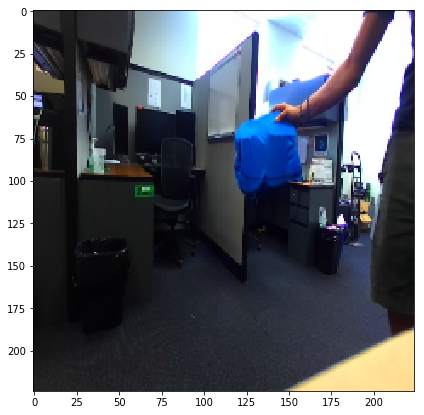

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import h5py
import numpy as np
import os

DATA = lambda p: os.path.join('../datafiles/zed-subset', p)

def myimread(fname):
    import skimage.io, skimage.transform
    im = skimage.transform.resize(skimage.io.imread(fname), (224, 224))
    return im[...,::-1]*255

def myimshow(im):
    plt.figure(figsize=(7,7))
    plt.imshow(im[...,::-1]/255)
    
def myimshow_grey(im):
    plt.figure(figsize=(7,7))
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

test_im = myimread(DATA('556-left.jpeg'))
print(test_im.shape)

myimshow(test_im)

In [2]:
def ConvMap(vgg_weights_path):
    REMOVE_EXCESSIVE_POOLING = True
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224), name='z11'))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv11'))
    model.add(ZeroPadding2D((1,1), name='z12'))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv12'))
    model.add(MaxPooling2D((2,2), strides=(2,2), name='max1'))

    model.add(ZeroPadding2D((1,1), name='z21'))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv21'))
    model.add(ZeroPadding2D((1,1), name='z22'))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv22'))
    model.add(MaxPooling2D((2,2), strides=(2,2), name='max2'))

    model.add(ZeroPadding2D((1,1), name='z31'))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv31'))
    model.add(ZeroPadding2D((1,1), name='z32'))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv32'))
    model.add(ZeroPadding2D((1,1), name='z33'))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv33'))
    if not REMOVE_EXCESSIVE_POOLING:
        model.add(MaxPooling2D((2,2), strides=(2,2), name='max3'))

    model.add(ZeroPadding2D((1,1), name='z41'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv41'))
    model.add(ZeroPadding2D((1,1), name='z42'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv42'))
    model.add(ZeroPadding2D((1,1), name='z43'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv43'))
    if not REMOVE_EXCESSIVE_POOLING:
        model.add(MaxPooling2D((2,2), strides=(2,2), name='max4'))

    model.add(ZeroPadding2D((1,1), name='z51'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv51'))
    model.add(ZeroPadding2D((1,1), name='z52'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv52'))
    model.add(ZeroPadding2D((1,1), name='z53'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv53'))
    model.add(MaxPooling2D((2,2), strides=(2,2), name='max5'))

    # model.add(Flatten())
    # model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1000, activation='softmax'))
    
    layer_key = {
        'z11': 'layer_0', 'conv11': 'layer_1',
        'z12': 'layer_2', 'conv12': 'layer_3',
        'max1': 'layer_4',
        'z21': 'layer_5', 'conv21': 'layer_6',
        'z22': 'layer_7', 'conv22': 'layer_8',
        'max2': 'layer_9',
        'z31': 'layer_10', 'conv31': 'layer_11',
        'z32': 'layer_12', 'conv32': 'layer_13',
        'z33': 'layer_14', 'conv33': 'layer_15',
        'max3': 'layer_16',
        'z41': 'layer_17', 'conv41': 'layer_18',
        'z42': 'layer_19', 'conv42': 'layer_20',
        'z43': 'layer_21', 'conv43': 'layer_22',
        'max4': 'layer_23',
        'z51': 'layer_24', 'conv51': 'layer_25',
        'z52': 'layer_26', 'conv52': 'layer_27',
        'z53': 'layer_28', 'conv53': 'layer_29',
        'max5': 'layer_30',
    }
    
    if REMOVE_EXCESSIVE_POOLING:
        del layer_key['max3'], layer_key['max4']

    with h5py.File(vgg_weights_path) as f:
        for name, layer in layer_key.iteritems():
            g = f[layer]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.get_layer(name).set_weights(weights)
    
    print('VGG loaded. (%d layers)'%len(model.layers))
    
    model.add(ZeroPadding2D((1,1), name='z61'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv61'))
    model.add(ZeroPadding2D((1,1), name='z62'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv62'))
    
    print('ConvMap completed. (%d layers)'%len(model.layers))
        
    for layer in model.layers:
        if 'conv' in layer.name or 'max' in layer.name:
            print(layer.name, layer.output_shape)

    return model

def predict(im):
    im[:,:] -= np.array([103.939, 116.779, 123.68])
    im = im.transpose((2,0,1))
    im = np.expand_dims(im, axis=0)
    model = ConvMap('vgg16_weights.h5')
    
    # sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # model.compile(optimizer=sgd, loss='categorical_crossentropy')
    out = model.predict(im)
    return out

conv_map = predict(test_im.copy())
print('conv_map', conv_map.shape)

VGG loaded. (29 layers)
ConvMap completed. (33 layers)
conv11 (None, 64, 224, 224)
conv12 (None, 64, 224, 224)
max1 (None, 64, 112, 112)
conv21 (None, 128, 112, 112)
conv22 (None, 128, 112, 112)
max2 (None, 128, 56, 56)
conv31 (None, 256, 56, 56)
conv32 (None, 256, 56, 56)
conv33 (None, 256, 56, 56)
conv41 (None, 512, 56, 56)
conv42 (None, 512, 56, 56)
conv43 (None, 512, 56, 56)
conv51 (None, 512, 56, 56)
conv52 (None, 512, 56, 56)
conv53 (None, 512, 56, 56)
max5 (None, 512, 28, 28)
conv61 (None, 512, 28, 28)
conv62 (None, 512, 28, 28)
conv_map (1, 512, 28, 28)


16 convmaps out of 512.
shape: (28, 28)


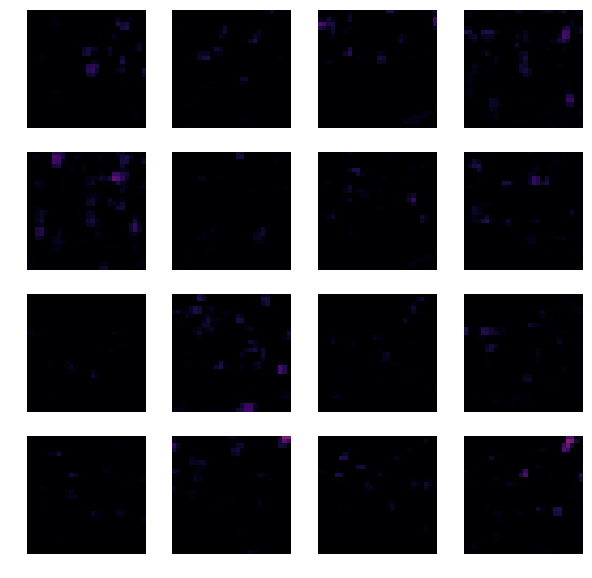

In [3]:
def show_conv_map(im):
    N_sumples = 16
    sample = np.random.choice(range(conv_map.shape[1]), N_sumples, False)
    print('%d convmaps out of %d.'%(N_sumples, conv_map.shape[1]))
    print('shape:', conv_map.shape[2:])
    plt.figure(figsize=(10,10))
    for i in xrange(N_sumples):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.imshow(conv_map[0][sample[i]], cmap=plt.get_cmap('inferno'), vmin=0, vmax=255)
    
show_conv_map(conv_map)

# Superpixel pooling

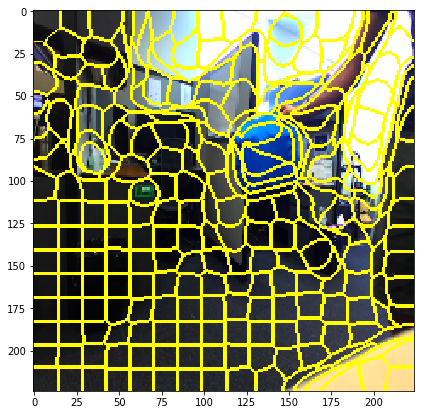

In [4]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

def myslic(im):
    im_float = im[...,::-1]/255
    segments = slic(im/255, n_segments = 250, sigma = 5)
    plt.figure(figsize=(7,7))
    plt.imshow(mark_boundaries(im_float, segments))
    return segments

test_segments = myslic(test_im)

(253, 28, 28) (1, 512, 28, 28)
(253, 512)


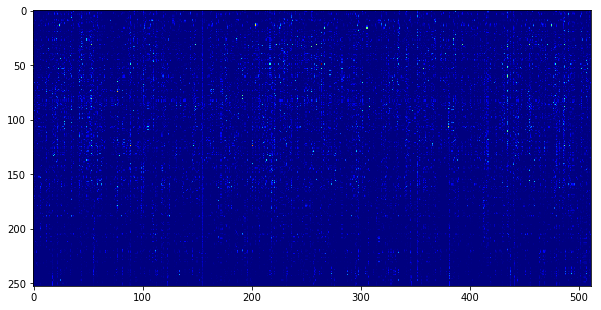

In [5]:
def superpixel_weights2(segments, conv_map):    
    N_segments = np.max(segments)+1
    subsample = tuple(np.array(segments.shape) / np.array(conv_map[0][0].shape))
    from skimage.util import view_as_blocks
    W = np.repeat(segments[np.newaxis,...],N_segments,axis=0)
    W = W==np.arange(N_segments)[...,np.newaxis,np.newaxis]
    W = np.sum(view_as_blocks(W, (1,)+subsample), axis=(3,4,5))
    # W_norm = np.sum(W,axis=(1,2))
    # W_norm[W_norm==0] = 1.
    # return W.astype(float)/W_norm[...,np.newaxis,np.newaxis]
    return W.astype(float)/np.sum(W,axis=(1,2))[...,np.newaxis,np.newaxis]

test_segments_weights = superpixel_weights2(test_segments, conv_map)

# Feature map (Unary potential)
print(test_segments_weights.shape, conv_map.shape)
H = np.einsum('tij,kij->tk', test_segments_weights, conv_map[0])
print(H.shape)
plt.figure(figsize=(10,7))
plt.imshow(H, cmap='jet')